In [1]:
# Import required libraries (1)
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import random
import torchvision.transforms as transforms

In [5]:
device = torch.device("cpu") # Due to some GPU constraints of Google Colab, we used CPU for training.

In [3]:
# Load the dataset (2)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_trainset = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
mnist_testset = datasets.MNIST(root='MNIST', download=True, train=False, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [16]:
# Take 1/4 of the dataset as D_pool and select the validation set size of 1000, as stated in the paper (3)

X_train = mnist_trainset.data.numpy()
y_train = mnist_trainset.targets.numpy()

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
X_test = mnist_testset.data.numpy()      # !
y_test = mnist_testset.targets.numpy()   # !
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

chunk_size = int (len(X_train) / 4)
X_train_indices, _ = torch.utils.data.random_split(X_train, [chunk_size, chunk_size*3])

X_train = X_train[X_train_indices.indices]
y_train = y_train[X_train_indices.indices]

X_val_indices, X_train_indices = torch.utils.data.random_split(X_train, [1000, len(X_train)-1000])

X_val = X_train[X_val_indices.indices]
y_val = y_train[X_val_indices.indices]

X_train = X_train[X_train_indices.indices]
y_train = y_train[X_train_indices.indices]

The label is: 0


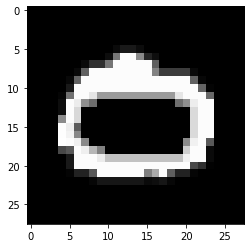

In [17]:
# Sanity check for train and validation sets (3.5)
def sanity_check(X, y, index):
  print("The label is: " + str(y[index]))
  plt.imshow(X[index], cmap='gray')
  plt.show()

sanity_check(X_train, y_train, 53)

In [18]:
# Define the CNN model (4)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)       
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
        self.fc1 = nn.Linear(18 * 18 * 32, 128)
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.maxpool1(x)
      x = F.relu(self.conv2(x))
      x = self.maxpool2(x)
      x = torch.flatten(x, 1)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      x = F.log_softmax(x, dim=1)
      # for log_softmax, pls read https://medium.com/@AbhiramiVS/softmax-vs-logsoftmax-eb94254445a2#

      return x

In [19]:
# Define training function (4.5) - This code is retrieved from the PA3 implementation of Ateş except early stopping part
# Early stopping part is derived from https://pythonguides.com/pytorch-early-stopping/
def train(model, criterion, optimizer, epochs, batch_size, X_train, y_train, patience, train_type, verbose=True):
  
  trigger_count = 0
  last_loss = float("inf")

  loss_history = [] 
  for epoch in range(epochs):

    dataset_size = X_train.shape[0]
    batch_count = int (dataset_size / batch_size)
    batch_boundaries = np.zeros((batch_count+1, 2))
    i = 0
    while i < batch_count:
      batch_boundaries[i] = [i*batch_size, (i+1)*batch_size]
      i += 1
    batch_boundaries[i] = [i*batch_size, dataset_size]
    batch_count += 1
    batch_boundaries = batch_boundaries.astype(int)

    for batch in range(batch_count):   
      
      # Our batch:
      inputs = X_train[batch_boundaries[i][0]:batch_boundaries[i][1]]
      labels = y_train[batch_boundaries[i][0]:batch_boundaries[i][1]]
      inputs = torch.from_numpy(inputs).float()
      labels = torch.from_numpy(labels)
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model(inputs)

      # Calculate loss
      if train_type == "raw":
        loss = criterion(outputs.to(device), labels)

      elif train_type == "pure":
        M = inputs.shape[0]
        N = X_test.shape[0]
        temp_pure = np.zeros((M,))
        for m in range(M):
          q = 1 / (N + (m+1) - 1)
          temp_pure[m] = (1 / (N*q)) + ((M-(m+1))/N)
        temp_pure = torch.from_numpy(temp_pure)
        loss_func = nn.NLLLoss(reduction='none')
        loss = torch.mean(temp_pure.clone() * loss_func(outputs.to(device), labels))

      else: # train_type == "lure"
        M = inputs.shape[0]
        N = X_test.shape[0]
        temp_lure = np.zeros((M,))
        for m in range(M):
          q = 1 / (N + (m+1) - 1)
          temp_lure[m] = 1 + ((N-M)/(N-(m+1)))*((1/((N-(m+1)+1)*q))-1)
        temp_lure = torch.from_numpy(temp_lure)
        loss_func = nn.NLLLoss(reduction='none')
        loss = torch.mean(temp_lure.clone() * loss_func(outputs.to(device), labels))


      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())
    
    if verbose: print(f'Epoch {epoch} / {epochs}: loss of the last iteration {loss_history[-1]}')

    # Early stopping mechanism
    validation_inputs = torch.from_numpy(X_val).float()
    validation_inputs = validation_inputs.reshape(validation_inputs.shape[0], 1, 28, 28)
    validation_outputs = torch.from_numpy(y_val)
    validation_inputs = validation_inputs.to(device)
    validation_outputs = validation_outputs.to(device)
    with torch.no_grad():
      validation_predictions = model(validation_inputs)
      validation_loss = criterion(validation_predictions.to(device), validation_outputs)
      current_loss = validation_loss.item()

    if current_loss > last_loss:
      trigger_count += 1
      if trigger_count >= patience:
        print("Validation loss: " + str(current_loss))
        return loss_history
    else:
        trigger_count = 0

    last_loss = current_loss

  print("Validation loss: " + str(last_loss))
  return loss_history

In [20]:
# Set initial D_train and D_pool (5)

D_train_indices, D_pool_indices = torch.utils.data.random_split(X_train, [10, len(X_train)-10]) # taking random 10 for training

D_train = X_train[D_train_indices.indices]
D_train = D_train.reshape(D_train.shape[0], 1, 28, 28)
D_train_labels = y_train[D_train_indices.indices]

D_pool = X_train[D_pool_indices.indices]
D_pool = D_pool.reshape(D_pool.shape[0], 1, 28, 28)
D_pool_labels = y_train[D_pool_indices.indices]

The label is: 9


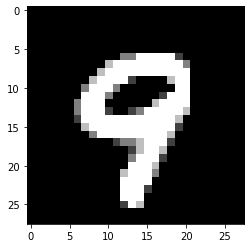

In [21]:
# Sanity check for D_train and D_pool (5.5)
def sanity_check_D(X, y, index):
  print("The label is: " + str(y[index]))
  plt.imshow(X[index][0], cmap='gray')
  plt.show()

sanity_check_D(D_train, D_train_labels, 8)

In [22]:
# Main loop (6)
internal_counter = 0
raw_loss_history = []
pure_loss_history = []
lure_loss_history = []
for i in range(90):  # since |D_train| goes from 10 to 100

  print("size(D_train) is " + str(len(D_train)) + " and size(D_pool) is " + str(len(D_pool)))
  
  # Create the model, set optimization and loss functions and train it!
  model = CNN()
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0005, amsgrad=True)
  model = model.to(device)
  epochs = 100
  batch_size = 64
  early_stopping = 20
  loss_history = train(model, criterion, optimizer, epochs, batch_size, D_train, D_train_labels, early_stopping, "raw", verbose=False)

  # Find the most uncertain prediction
  with torch.no_grad():
    X_pool = torch.from_numpy(D_pool).float()
    X_pool = X_pool.to(device)
    predictions = model(X_pool)
    max_scores = torch.max(predictions, 1)
    uncertain_index  = torch.argmin(max_scores[0])

  # Take the most uncertain example from D_pool to D_train
  D_train = np.append(D_train, [D_pool[uncertain_index]], axis=0)
  D_train_labels = np.append(D_train_labels, [D_pool_labels[uncertain_index]], axis=0)
  D_pool = np.delete(D_pool, uncertain_index, axis=0)
  D_pool_labels = np.delete(D_pool_labels, uncertain_index, axis=0)

  # Determine every 3 iteration
  internal_counter += 1
  if internal_counter == 3:
    print("3 iteration is occured!")
    internal_counter = 0
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    X_testing = torch.from_numpy(X_test).float()    
    y_testing = torch.from_numpy(y_test)
    
    # train using R~
    with torch.no_grad():
      raw_predictions = model(X_testing)
      raw_loss = criterion(raw_predictions.to(device), y_testing)
      raw_loss_history.append(raw_loss.item())
      print("Raw loss is: " + str(raw_loss.item()))

    # train using R_pure~
    # print("PURE adventure is starting...")
    model_pure = CNN()
    model_pure = model_pure.to(device)
    loss_history = train(model_pure, criterion, optimizer, epochs, batch_size, D_train, D_train_labels, early_stopping, "pure", verbose=False)
    with torch.no_grad():
      pure_predictions = model_pure(X_testing)
      pure_loss = criterion(pure_predictions.to(device), y_testing)
      pure_loss_history.append(pure_loss.item())
      print("Pure loss is: " + str(pure_loss.item()))

    #train using R_lure~
    model_lure = CNN()
    model_lure = model_lure.to(device)
    loss_history = train(model_lure, criterion, optimizer, epochs, batch_size, D_train, D_train_labels, early_stopping, "lure", verbose=False)
    with torch.no_grad():
      lure_predictions = model_lure(X_testing)
      lure_loss = criterion(lure_predictions.to(device), y_testing)
      lure_loss_history.append(lure_loss.item())
      print("Lure loss is: " + str(lure_loss.item()))

size(D_train) is 10 and size(D_pool) is 13990
Validation loss: 10.542021751403809
size(D_train) is 11 and size(D_pool) is 13989
Validation loss: 17.551481246948242
size(D_train) is 12 and size(D_pool) is 13988
Validation loss: 16.519573211669922
3 iteration is occured!
Raw loss is: 16.246381759643555
Validation loss: 7.835407733917236
Pure loss is: 7.698727130889893
Validation loss: 7.835407733917236
Lure loss is: 7.698727130889893
size(D_train) is 13 and size(D_pool) is 13987
Validation loss: 14.025339126586914
size(D_train) is 14 and size(D_pool) is 13986
Validation loss: 7.891455173492432
size(D_train) is 15 and size(D_pool) is 13985
Validation loss: 12.772120475769043
3 iteration is occured!
Raw loss is: 12.823562622070312
Validation loss: 7.835407733917236
Pure loss is: 7.698727130889893
Validation loss: 7.835407733917236
Lure loss is: 7.698727130889893
size(D_train) is 16 and size(D_pool) is 13984
Validation loss: 15.928507804870605
size(D_train) is 17 and size(D_pool) is 13983
V

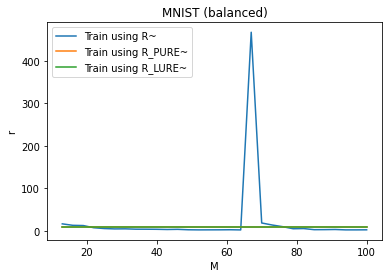

In [26]:
# Visualize the results (7)
M = [13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94, 97, 100]
plt.plot(M, raw_loss_history, label = "Train using R~")
plt.plot(M, pure_loss_history, label = "Train using R_PURE~")
plt.plot(M, lure_loss_history, label = "Train using R_LURE~")
plt.xlabel('M')
plt.ylabel('r')
plt.title("MNIST (balanced)")
plt.legend()
plt.show()

In [28]:
raw_loss_history[18]

466.8888854980469

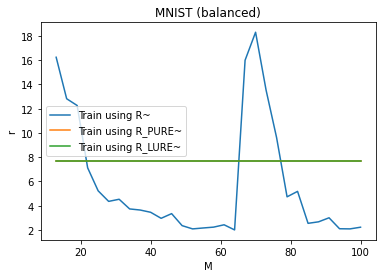

In [30]:
# To better visualize, we smooth the "outlier" loss with a constant. (7.5)
raw_loss_history[18] = 16.0
plt.plot(M, raw_loss_history, label = "Train using R~")
plt.plot(M, pure_loss_history, label = "Train using R_PURE~")
plt.plot(M, lure_loss_history, label = "Train using R_LURE~")
plt.xlabel('M')
plt.ylabel('r')
plt.title("MNIST (balanced)")
plt.legend()
plt.show()